# Getting started with vdmlab

The purpose of this notebook is a brief introduction to the features available in `vdmlab`.

Let's start by importing packages that will be useful for plotting, fast computations, and our vdmlab code.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from shapely.geometry import Point, LineString

import vdmlab as vdm

`vdmlab` uses objects for the data common to recording experiments to facilitate computations. Using objects in this way can hide some complexities, making project code more readable and reliable. That being said, object-oriented programming is a whole area onto itself and can be challenging to dive into! If you find classes, attributes, and methods confusing then don't hesitate to look up resources with search terms like 'python', 'pycon', and 'object-oriented'.

The specific objects in `vdmlab` are found in vdmlab.core and documentation can be found here [http://python-vdmlab.readthedocs.io/en/latest/core.html]. In short, the objects we use are:

`AnalogSignal`: with parameters `data` and `time`

`LocalFieldPotential`: with parameters `data` and `time`

`Position`: with parameters `data` and `time`

`Epoch`: with parameters `time` and `duration`

`SpikeTrain`: with parameters `time` and [optional] `label`

In practice, recording data will fall into a `LocalFieldPotential`, `Position`, `Epoch`, or `SpikeTrain` class. Let's walk through some examples that use each of these objects to get a better understanding of what they are and how they're used!

# LocalFieldPotential

A common `AnalogSignal` is the `LocalFieldPotential` (LFP) data (aka. CSC (Continuously Sampled Channel) from Neuralynx). Here we actually have the `LocalFieldPotential` inheriting from the `AnalogSignal` class, so we can talk about them together. Currently the implementation of `LocalFieldPotential` does not have unique features (methods or attributes) that are not part of `AnalogSignal`.

Parameters: `data` and `time`

In [2]:
lfp_time = np.arange(0, 100, 1)
lfp_data = np.sin(lfp_time ** 2)

lfp = vdm.AnalogSignal(lfp_data, lfp_time)

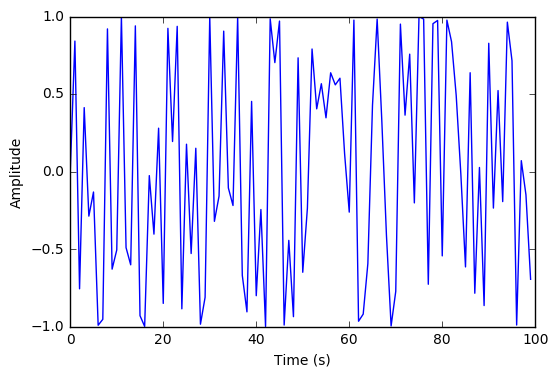

In [3]:
# We can plot our LFP to see what it looks like
plt.plot(lfp.time, lfp.data)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.show()

What we're looking at is the amplitude of the LFP on the y-axis and time on the x-axis! Now, let's get to know some of the attributes of our LFP object...

In [4]:
# How many samples do we have? (we expect 100)
print(lfp.n_samples)

100


In [5]:
# How many dimensions are our LFP data? (we expect 1)
print(lfp.dimensions)

1


Let's index into this LFP object to a specific time of interest.

In [6]:
time_start = 40
time_stop = 60
mid_lfp = lfp.time_slice(time_start, time_stop)

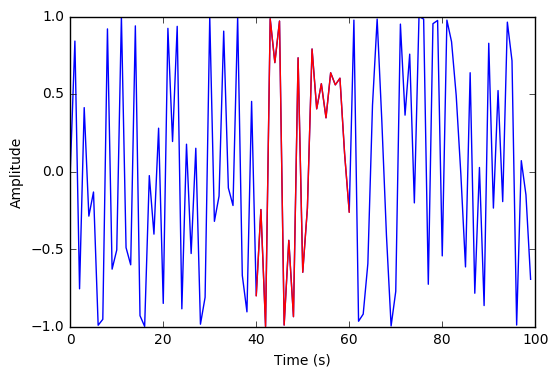

In [7]:
# Let's plot this new mid_lfp over (in RED) our longer lfp (in BLUE) to see how it's been sliced.
plt.plot(lfp.time, lfp.data, 'b')
plt.plot(mid_lfp.time, mid_lfp.data, 'r', ms=3)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.show()

So, the slice has the same data and time but limited within our desired start, stop times. 

# Position

Another subclass from `AnalogSignal` is `Position`. The intended purpose of `Position` is literally the data tracking the position of the subject throughout the experiment. This can be the 2D position from the Neuralynx video tracking (vt) or compressed 1D position constructed during analysis.

Parameters: `data` and `time`

In [8]:
n_laps = 2
theta = np.linspace(-n_laps * np.pi, n_laps * np.pi, num=100)
position_x = np.cos(theta)
position_y = np.sin(theta)

position_time = np.arange(0, 100, 1)
position_data = np.hstack([position_x[:, np.newaxis], position_y[:, np.newaxis]])

position = vdm.Position(position_data, position_time)

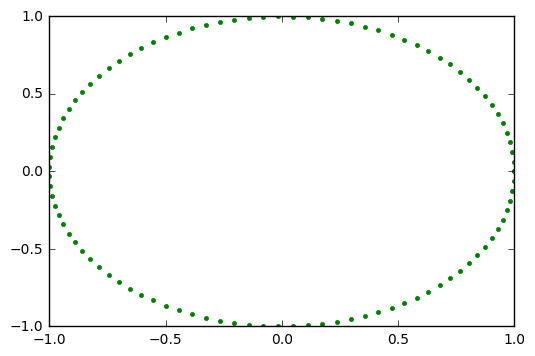

In [9]:
# Let's plot the x, y (2D) position of our subject with green dots
plt.plot(position.x, position.y, 'g.')
plt.show()

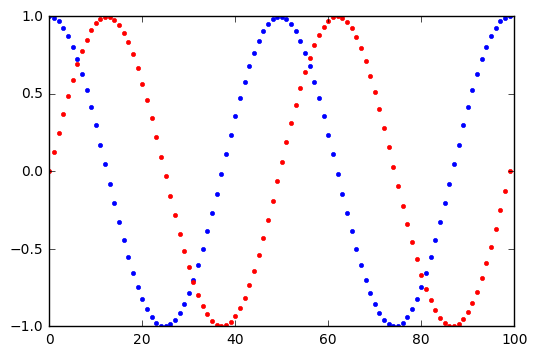

In [10]:
# Now let's plot the x position by time in blue and y position by time in red
plt.plot(position.time, position.x, 'b.')
plt.plot(position.time, position.y, 'r.')
plt.show()

To linearize our 2D position, we need to define our ideal trajectory and zone of interest.

In [11]:
# Defining the "ideal trajectory"
theta = np.linspace(-np.pi, np.pi, num=10)
ideal_x = np.cos(theta)
ideal_y = np.sin(theta)

ideal_line = []
for x, y in zip(ideal_x, ideal_y):
    ideal_line.append([x, y])
    
line = LineString(ideal_line)

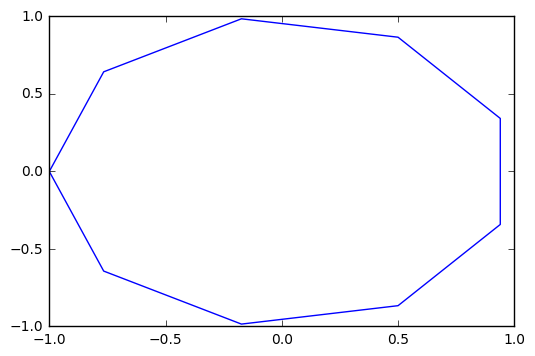

In [12]:
plt.plot(line.xy[0], line.xy[1])
plt.show()

In [13]:
# Defining the zone of interest

zone_start = Point([-1., -1.])
zone_stop = Point([1., 1.])
expand_by = 0.5
zone = vdm.expand_line(zone_start, zone_stop, line, expand_by)

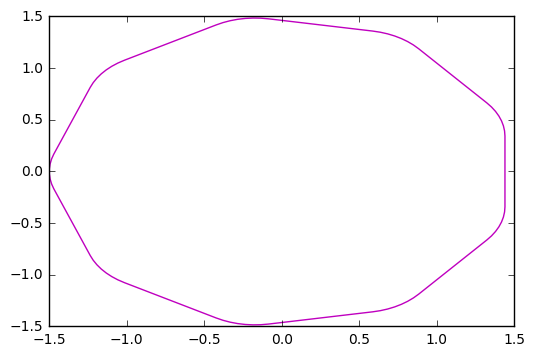

In [14]:
plt.plot(zone.exterior.xy[0], zone.exterior.xy[1], 'm', lw=1)
plt.show()

Let's check that these are as expected by plotting them all in the same figure! 

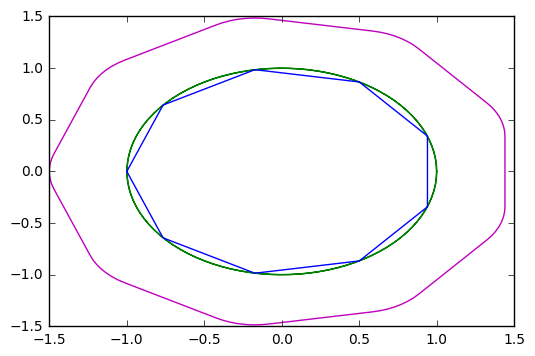

In [15]:
plt.plot(position.x, position.y, 'g')
plt.plot(line.xy[0], line.xy[1])
plt.plot(zone.exterior.xy[0], zone.exterior.xy[1], 'm', lw=1)
plt.show()

In [16]:
linear = position.linearize(line, zone)

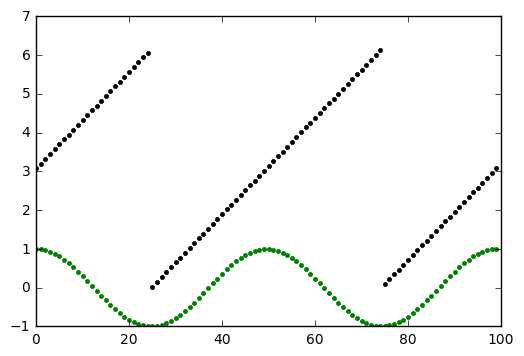

In [17]:
# Since the circle goes from -2*pi to 2*pi, those are the values we expect to see for the linearized positions
plt.plot(position.time, position.x, 'g.')
plt.plot(linear.time, linear.x, 'k.')
plt.show()

# Epoch

The `Epoch` class is for events with associated time periods. These can be events from Neuralynx; eg. trial start/stop, feeder firing, photobeam breaks, etc. Or, it can be epochs specified during the analysis; eg. sharp-wave ripple epochs in the lfp.

Parameters: `time`, `duration` [optional]

In [18]:
starts = np.array([0., 20., 70.])
stops = np.array([5., 30., 90.])
durations = np.array([5., 10., 20.])

In [19]:
# We can define our epochs using start and stop times
epochs = vdm.Epoch(np.hstack([starts[:, np.newaxis], stops[:, np.newaxis]]))

# Or with start times and epoch durations
epochs = vdm.Epoch(starts, durations)

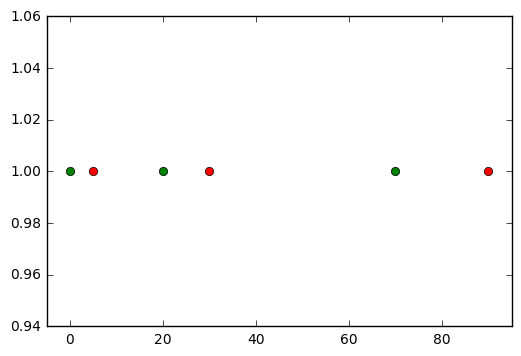

In [20]:
# Let's take a look at our epochs! Here we'll plot starts in green and stops in red.
plt.plot(epochs.starts, np.ones(len(epochs.starts)), 'o', color='g')
plt.plot(epochs.stops, np.ones(len(epochs.stops)), 'o', color='r')
plt.xlim(epochs.start - 5, epochs.stop + 5)
plt.show()

In [21]:
# What are the epoch durations?
get_durations = epochs.durations
print(get_durations)

[  5.  10.  20.]


In [22]:
# What are the centers of each epoch?
get_centers = epochs.centers
print(get_centers)

[  2.5  25.   80. ]


In [23]:
# How many epochs are we working with here?
get_n_epochs = epochs.n_epochs
print(get_n_epochs)

3


In [24]:
# What is the first start epoch and last stop epoch?
first = epochs.start
print(first)

last = epochs.stop
print(last)

0.0
90.0


In [25]:
# What are all the epoch starts and stops?
starts = epochs.starts
print(starts)

stops = epochs.stops
print(stops)

[  0.  20.  70.]
[  5.  30.  90.]


In [26]:
# Let's add 0.1 buffer on either side of our epochs
buffered_epochs = epochs.expand(0.1)
print(buffered_epochs.starts)
print(buffered_epochs.stops)

[ -0.1  19.9  69.9]
[  5.1  30.1  90.1]


In [27]:
# Alternatively, let's reduce our epoch by 0.1 on either side
reduced_epochs = epochs.shrink(0.1)
print(reduced_epochs.starts)
print(reduced_epochs.stops)

[  0.1  20.1  70.1]
[  4.9  29.9  89.9]


With another epoch we can do things like find the intersection between the two or join them.

In [28]:
other_epochs = vdm.Epoch(0, 50)

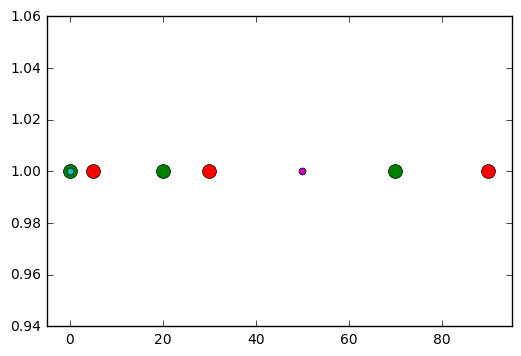

In [29]:
# Let's take a look at our new epoch compared to the old ones! Here we'll keep the old epochs starts in green and stops in red,
# but make the other_epochs in cyan (start) and magenta (stop) (and smaller so we can see the overlap).
plt.plot(epochs.starts, np.ones(len(epochs.starts)), 'o', color='g', ms=10)
plt.plot(epochs.stops, np.ones(len(epochs.stops)), 'o', color='r', ms=10)
plt.plot(other_epochs.starts, np.ones(len(other_epochs.starts)), 'o', color='c', ms=5)
plt.plot(other_epochs.stops, np.ones(len(other_epochs.stops)), 'o', color='m', ms=5)
plt.xlim(epochs.start - 5, epochs.stop + 5)
plt.show()

In [30]:
intersected = epochs.intersect(other_epochs)
print(intersected.starts, intersected.stops)

[  0.  20.] [  5.  30.]


# SpikeTrain

A SpikeTrain has a `time` array of timestamps corresponding with the times that neuron fired an action potential. The [optional] `label` contains information specific to that neuron, such as which tetrode it was recorded from.

Parameters: `time` and `label`

In [31]:
spikes = vdm.SpikeTrain(np.arange(0, 100, 2), 'made up')

In [32]:
# Let's see what our spike times looks like
spikes.time

array([  0.,   2.,   4.,   6.,   8.,  10.,  12.,  14.,  16.,  18.,  20.,
        22.,  24.,  26.,  28.,  30.,  32.,  34.,  36.,  38.,  40.,  42.,
        44.,  46.,  48.,  50.,  52.,  54.,  56.,  58.,  60.,  62.,  64.,
        66.,  68.,  70.,  72.,  74.,  76.,  78.,  80.,  82.,  84.,  86.,
        88.,  90.,  92.,  94.,  96.,  98.])

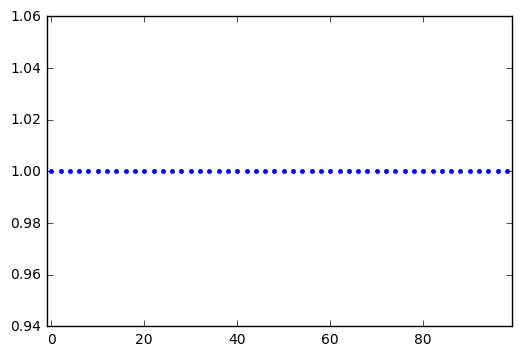

In [33]:
# Or, in plot format
plt.plot(spikes.time, np.ones(len(spikes.time)), 'b.')
plt.xlim(min(spikes.time)-1, max(spikes.time)+1)
plt.show()

In [34]:
# And how do we access that label parameter?
print(spikes.label)

made up


In [35]:
# Now, what if we were only interested in the spike that occur during our first epoch?
start = epochs.starts[0]
stop = epochs.stops[0]
epoch0_spikes = spikes.time_slice(start, stop)

print(epoch0_spikes.time)

[ 0.  2.  4.]


This concludes our introduction to the data structures in the `vdmlab` repository. Namely, we saw `LocalFieldPotential`, `Position`, `Epoch`, and `SpikeTrain`. Most in vivo electrophisiology analyses depend on these four objects and their interactions.

## Real world

With real data, a typical start-up would look something more like this:

```python

import matplotlib.pyplot as plt
import numpy as np
import os
import vdmlab as vdm
import info

thisdir = os.path.dirname(os.path.realpath(__file__))
pickle_filepath = os.path.join(thisdir, 'cache', 'data')

position_filepath = os.path.join(data_filepath, info.position_file)
lfp_filepath = os.path.join(data_filepath, info.lfp_file)
spikes_filepath = os.path.join(data_filepath, info.spikes_file)
events_filepath = os.path.join(data_filepath, info.events_file)

position = vdm.load_position(position_filepath, info.pxl_to_cm)
lfp = vdm.load_spikes(lfp_filepath)
spikes = vdm.load_spikes(spikes_filepath)
events = load_events(events_filepath, info.event_labels)

```

Notice that `np` and `plt` were not used here, but often they'll be used later in the analysis for computations and plotting.